<a href="https://colab.research.google.com/github/johnberg1/COMP447-547/blob/main/homework3/HW3_VAE_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Blackboard, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In this homework, you will be implementing VAE and GAN models. 

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

You will be implementing the code using PyTorch. Some parts of the code such as function headers are already provided to you, you will need to fill out the parts with "YOUR CODE HERE". Feel free to create more cells and more functions or modify the existing ones if you wish.

After you complete the assignment, download all of the image outputted in the results/ folder (which you can find on the left dashboard by clicking the folder icon) and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [2]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/johnberg1/deepul.git
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 138 (delta 44), reused 115 (delta 21), pack-reused 0
Receiving objects: 100% (138/138), 60.52 MiB | 26.08 MiB/s, done.
Resolving deltas: 100% (44/44), done.
--2021-04-25 18:58:41--  https://docs.google.com/uc?export=download&confirm=P7Ya&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 74.125.142.101, 74.125.142.102, 74.125.142.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-4k-docs.googleusercontent.com/docs/securesc/7v0c72ju15mpifglu5a34s9d0i0hg0ii/el7jrk3d8m15rh8od39e12rcid0t6bbo/1619377050000/06419056966375271799/14044455506394409193Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2021-04-25 18:58:41--  https://doc-08-4k-docs.googleu

In [3]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

# Question 1: Warmup [20pts]
In this question, you will train a simple VAE on 2D data in part(a), and a GAN on 1D data in part(b)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


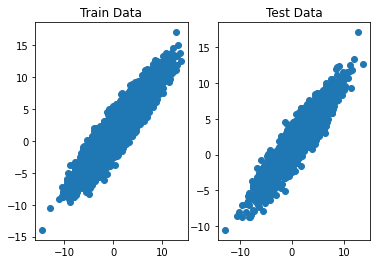

Dataset 2


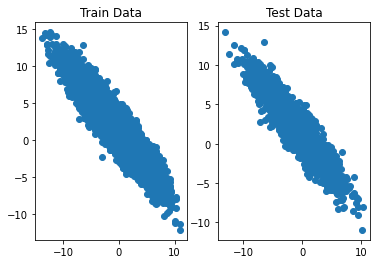

In [ ]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-\log{p(x|z)}]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

**Hint:** Implement your encoder and decoder architectures as MLPs. Two hidden layers with 128 hidden sizes should be enough for this part. 

It might be helpful for you to take a look at torch.distributions for the calculation of the losses.

Class headers are provided here for reference. You may want to use these or change them. Again, you can define generic train and test functions to use in these parts.

In [4]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [5]:
class MLP(nn.Module):
  # A generic MLP class which you can use in different parts
  """ YOUR CODE HERE """
  def __init__(self, in_size, hidden_sizes_list, out_size, leaky = False):
    super().__init__()

    model = []
    pre_size = in_size
    for l in hidden_sizes_list + [out_size]:
      model.append(nn.Linear(pre_size, l))
      if leaky:
        model.append(nn.LeakyReLU(0.2))
      else:  
        model.append(nn.ReLU())
      pre_size = l

    model.pop()
    self.model = nn.Sequential(*model)

  def forward(self,x):
    return self.model(x)


In [ ]:
class FullyConnectedVAE(nn.Module):
  # Create your VAE model here. Encoder and decoder should be MLPs
  """ YOUR CODE HERE """
  def __init__(self, input_size, latent_size, enc_hidd_size_list, dec_hidd_size_list):
    super().__init__()

    self.encoder = MLP(input_size, enc_hidd_size_list, 2 * input_size)
    self.decoder = MLP(latent_size, dec_hidd_size_list, 2 * latent_size)
    self.latent_size = latent_size

  def train_batch(self,x):
    mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
    z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
    mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)

    #reconstruction loss
    recon_loss = 0.5 * np.log(2 * np.pi) + log_std_x + (x - mu_x) ** 2 * torch.exp(-2 * log_std_x) * 0.5
    recon_loss = recon_loss.sum(1).mean()

    #kl term ELBO
    kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
    kl_loss = kl_loss.sum(1).mean()

    elbo = recon_loss + kl_loss

    return elbo, recon_loss, kl_loss

  def sample(self, n, noise=True):
    with torch.no_grad():
      z = torch.randn(n, self.latent_size).cuda()
      mu, log_std = self.decoder(z).chunk(2, dim=1)
      if noise:
        z = torch.randn_like(mu) * log_std.exp() + mu
      else:
        z = mu
    return z.cpu().numpy()    

after MLP from input space to latent space (encoder step):
$$[x_1,x_2]\ -> [\mu_{z_1},\mu_{z_2},\sigma_{z_1},\sigma_{z_2}]$$
then sample from standart normal : $\epsilon_1$, $\epsilon_2$
$$[z_1,z_2] = [\sigma_{z_1} \epsilon_1 + \mu_{z_1},\sigma_{z_2} \epsilon_2 + \mu_{z_2}]$$
after MLP from latent space to input space for reconstruction (decoder step):
$$[z_1,z_2]\ -> [\mu_{x_1},\mu_{x_2},\sigma_{x_1},\sigma_{x_2}]$$
(same for $x_1$, $x_2$) find reconstraction loss:
$$\mathbb{E}_{x_1}\mathbb{E}_{q_\phi(z_1|x_1)}\left[ -log\ p_\theta(x_1|z_1)\right] = \mathbb{E}_{x_1}\left[ -log\ \left( \frac{1}{\sqrt{2\pi}\sigma_{x_1}}e^{-\frac{(x_1-\mu_{x_1})^2}{2\sigma_{x_1}^2}}\right) \right] =\frac{1}{\#batch}\sum_{x_1} \left(\frac{log(2\pi)}{2} + log\ \sigma_{x_1} + \frac{(x_1-\mu_{x_1})^2}{2\sigma_{x_1}^2}\right) $$
(same for $x_1$, $x_2$) find KL (regularization) term for ELBO:
\begin{equation}
  \begin{aligned}
\mathbb{E}_{x_1}KL(q_\phi(z_1|x_1)||p(z_1)) 
&= \mathbb{E}_{x_1} \mathbb{E}_{q_\phi(z_1|x_1)}\left[ log\frac{q_\phi(z_1|x_1)}{p(z_1)}\right] 
= \mathbb{E}_{x_1} \mathbb{E}_{q_\phi(z_1|x_1)}\left[log\frac{\frac{1}{\sqrt{2\pi}\sigma_{z_1}}e^{-\frac{(z_1-\mu_{z_1})^2}{2\sigma^2_{z_1}}}}{\frac{1}{\sqrt{2\pi}}e^{-\frac{z_1^2}{2}}}\right] 
= \mathbb{E}_{x_1} \mathbb{E}_{q_\phi(z_1|x_1)}\left[ log\frac{e^{\frac{z_1^2}{2}-\frac{(z_1-\mu_{z_1})^2}{2\sigma_{z_1}^2}}}{\sigma_{z_1}}\right] \\
&= \mathbb{E}_{x_1} \mathbb{E}_{q_\phi(z_1|x_1)}\left[-log\ \sigma_{z_1} + \frac{z_1^2}{2} - \frac{(z_1-\mu_{z_1})^2}{2\sigma_{z_1}^2}\right] \\
&= \mathbb{E}_{x_1} \left[ -log\ \sigma_{z_1} + \mathbb{E}_{q_\phi(z_1|x_1)}\left[\frac{z_1^2}{2}\right]-\mathbb{E}_{q_\phi(z_1|x_1)}\left[ \frac{(z_1-\mu_{z_1})^2}{2\sigma_{z_1}^2}\right]\right] 
= \mathbb{E}_{x_1} \left[ -log\ \sigma_{z_1} + \mathbb{E}_{q_\phi(z_1|x_1)}\left[\frac{(z_1-\mu_{z_1} + \mu_{z_1})^2}{2}\right]-\frac{1}{2}\right] \\
&= \mathbb{E}_{x_1} \left[ -log\ \sigma_{z_1} + \mathbb{E}_{q_\phi(z_1|x_1)}\left[\frac{(z_1-\mu_{z_1})^2 + (\mu_{z_1})^2}{2}+z_1\mu_{z_1}-\mu_{z_1}^2\right]-\frac{1}{2}\right] 
= \mathbb{E}_{x_1} \left[ -log\ \sigma_{z_1} + \frac{\sigma_{z_1}^2}{2} + \frac{\mu_{z_1}^2}{2} -\frac{1}{2}\right] \\
&= \frac{1}{\#batch}\sum_{x_1} \left( -log\ \sigma_{z_1} + \frac{\sigma_{z_1}^2}{2} + \frac{\mu_{z_1}^2}{2} -\frac{1}{2}\right)
   \end{aligned}
 \end{equation} 

 sampling:
$$[z_1,z_2] \sim \mathcal{N}(0,1)\ \ then\ \ decoder[z_1,z_2]\ -> use\ [\mu_{x_1},\mu_{x_2}] = [x_1,x_2]_{sample}$$
or by adding standart gaussian noise $\epsilon_1,\epsilon_2$,
$$[z_1,z_2] \sim \mathcal{N}(0,1)\ \ then\ \ decoder[z_1,z_2]\ -> use\ [\sigma_{x_1}\epsilon_1 + \mu_{x_1},\sigma_{x_2}\epsilon_2 + \mu_{x_2}] = [x_1,x_2]_{sample}$$

In [4]:
def eval_loss(model, data_loader):
  model.eval()
  total_elbo = 0
  total_recon_loss = 0
  total_kl_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.cuda()
      elbo, recon_loss, kl_loss = model.train_batch(x)
      total_elbo += elbo * x.shape[0]
      total_recon_loss += recon_loss * x.shape[0]
      total_kl_loss += kl_loss * x.shape[0]

    avg_elbo = total_elbo / len(data_loader.dataset)
    avg_recon_loss = total_recon_loss / len(data_loader.dataset)
    avg_kl_loss = total_kl_loss / len(data_loader.dataset)

  return avg_elbo.item(), avg_recon_loss.item(), avg_kl_loss.item()

In [ ]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """ 
    model = FullyConnectedVAE(2, 2, [128, 128], [128, 128]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    elbo_losses, recon_losses, kl_losses, test_elbo_losses, test_recon_losses, test_kl_losses = [], [], [], [], [], []

    for epoch in range(10):
      model.train()
      elbo_lss, recon_lss, kl_lss = [], [], []
      for x in train_loader:
        x = x.cuda()
        elbo, recon_loss, kl_loss = model.train_batch(x)
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        elbo_lss.append(elbo.item())
        recon_lss.append(recon_loss.item())
        kl_lss.append(kl_loss.item())

      elbo_losses.extend(elbo_lss)
      recon_losses.extend(recon_lss)
      kl_losses.extend(kl_lss)

      test_elbo_lss, test_recon_lss, test_kl_lss = eval_loss(model, test_loader)
      test_elbo_losses.append(test_elbo_lss)
      test_recon_losses.append(test_recon_lss)
      test_kl_losses.append(test_kl_lss)

    train_losses = np.stack((elbo_losses, recon_losses, kl_losses), axis=1)
    test_losses = np.stack((test_elbo_losses, test_recon_losses, test_kl_losses), axis=1)

    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 4.4474, Recon Loss: 2.7908, KL Loss: 1.6566


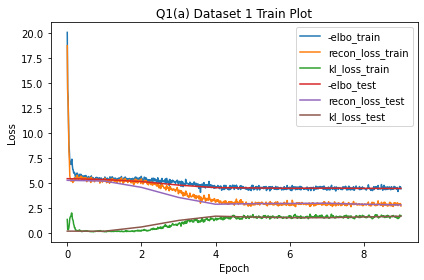

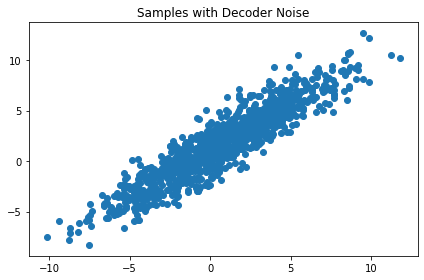

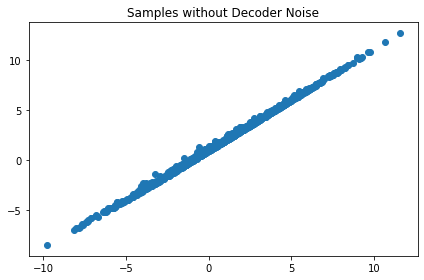

In [ ]:
q1_a_save_results('a', 1, q1)

Final -ELBO: 4.4675, Recon Loss: 2.8927, KL Loss: 1.5748


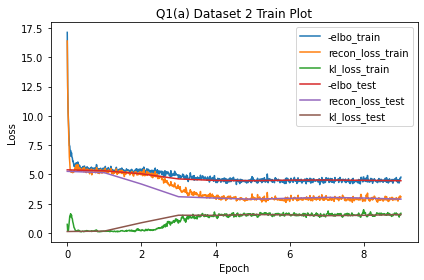

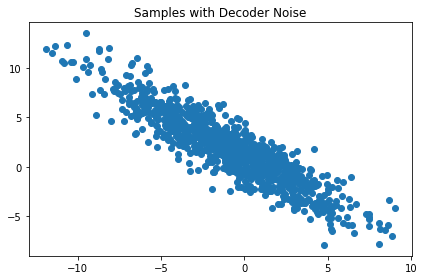

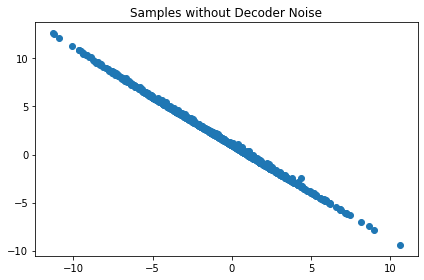

In [ ]:
q1_a_save_results('a', 2, q1)

## Part (b) GAN on 1D data [10 pts]
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 

Execute the cell below to visualize our datasets.

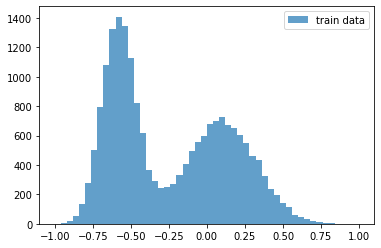

In [ ]:
visualize_q1_dataset()

### Solution

**Hints:**
- Again, some class headers are provided here, you may modify them if you wish. 
- You can use the generic MLP class from the first part for your generator and discriminator
- Use tanh nonlinearity in the output of your Generator and sigmoid for your Discriminator

In [6]:
class MLPGenerator(nn.Module):
  """ YOUR CODE HERE """
  def __init__(self, in_size, hidden_sizes_list, out_size):
    super().__init__()
    self.mlp = MLP(in_size, hidden_sizes_list, out_size, leaky = True)
    self.in_size = in_size

  def forward(self,z):
    return torch.tanh(self.mlp(z))

  def sample(self,n):
    z = torch.normal(torch.zeros((n,self.in_size)).cuda(),torch.ones((n,self.in_size)).cuda())
    return self.forward(z)

In [7]:
class MLPDiscriminator(nn.Module):
  """ YOUR CODE HERE """
  def __init__(self, in_size, hidden_sizes_list, out_size):
    super().__init__()
    self.mlp = MLP(in_size, hidden_sizes_list, out_size, leaky = True)

  def forward(self,xz):
    return torch.sigmoid(self.mlp(xz))

In [8]:
def draw_samples(generator, discriminator, n):
  generator.eval()
  discriminator.eval()
  samples = generator.sample(n).to('cpu').detach().numpy()
  x_axis = np.linspace(-1, 1, 1000)
  disc_response = discriminator.forward(torch.FloatTensor(x_axis).cuda().unsqueeze(1)).to('cpu').detach().numpy()
  return samples, x_axis, disc_response

----------------------------
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
\
$$\implies min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log\ \sigma (MLP_D(x))] + \mathbb{E}_{z \sim p(z)}[\log\ (1-\sigma (MLP_D(MLP_G(z))))]\ ;\ \ \ \ \ \sigma : sigmoid$$ \

-------------------------

* take batch x and generate fake data with $MLP_G(z)$ where $z \sim \mathcal{N}(0,1)$

$$minimize\ by\ (-discriminator)\ (n\ times)\ ->\ -\frac{1}{\#batch}\sum_x log\ \sigma (MLP_D(x))-\frac{1}{\#batch}\sum_z log\ (1-\sigma (MLP_D(MLP_G(z))))$$

-----------------------

* generate fake data with $MLP_G(z)$ where $z \sim \mathcal{N}(0,1)$ again

$$minimize\ by\ generator\ ->\ \frac{1}{\#batch}\sum_z log\ (1 - \sigma (MLP_D(MLP_G(z))))$$ 

-----------------------

In [17]:
def q1_b(train_data):
  """
  train_data: An (20000, 1) numpy array of floats in [-1, 1]

  Returns
  - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
  - a numpy array of size (5000,) of samples drawn from your model at epoch #1
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at epoch #1

  - a numpy array of size (5000,) of samples drawn from your model at the end of training
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at the end of training
  """
  
  """ YOUR CODE HERE """
  train_loader = data.DataLoader(train_data, batch_size=8, shuffle=True)

  generator = MLPGenerator(1,[128,128,128],1).cuda()
  discriminator = MLPDiscriminator(1,[128,128,128],1).cuda()

  #first train discriminator 2 times, then generator
  def discriminator_loss(generator, discriminator, x):
    fake_data = generator.sample(x.shape[0])
    return -discriminator(x).log().mean() -(1-discriminator(fake_data)).log().mean()

  def generator_loss(generator, discriminator, x):
    fake_data = generator.sample(x.shape[0])
    return (1-discriminator(fake_data)).log().mean()

  optimizer_disc = optim.Adam(discriminator.parameters(), lr=1e-4)
  optimizer_gen = optim.Adam(generator.parameters(), lr=1e-4)

  disc_losses = []
  for epoch in range(25):
    if epoch == 1:
      samples_ep1, x_axis_ep1, disc_response_ep1 = draw_samples(generator, discriminator, 5000)
    generator.train()
    discriminator.train()
    disc_loss = []
    for i, x in enumerate(train_loader):
      x = x.cuda().float()
      dl = discriminator_loss(generator, discriminator,x)
      optimizer_disc.zero_grad()
      dl.backward()
      optimizer_disc.step()
      disc_loss.append(dl.item())
      if i%2==0:
        gl = generator_loss(generator,discriminator,x)
        optimizer_gen.zero_grad()
        gl.backward()
        optimizer_gen.step()

    disc_losses.extend(disc_loss)

  samples, x_axis, disc_response = draw_samples(generator, discriminator, 5000)  
  
  return disc_losses, samples_ep1, x_axis_ep1, disc_response_ep1, samples, x_axis, disc_response

### Results

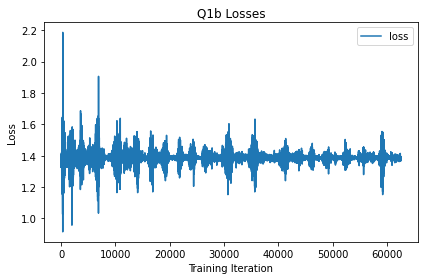

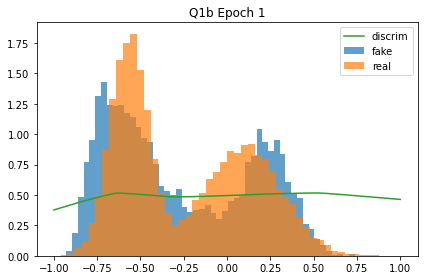

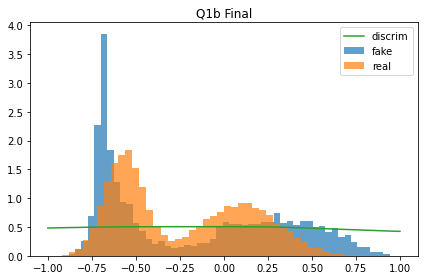

In [18]:
q1_b_save_results('a', q1_b)

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

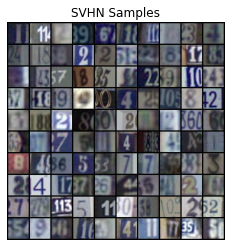

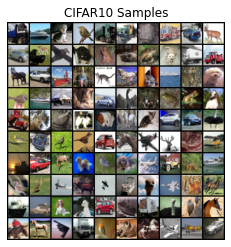

In [5]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1) # 32 x 32 (input)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim) # latent_dim = 16

Decoder
    linear(latent_dim, 4 * 4 * 128)
    reshape(128,4,4)
    relu()
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

**VAE on Images notes:** latent space dim is 16. Inputs are 32x32 images.

after some CONV2D layers, encoder outputs:
$$x\ -> [\mu_{z_1}...\mu_{z_{16}},\sigma_{z_1}...\sigma_{z_{16}}]$$
then sample from standart normal : $\epsilon_1$... $\epsilon_{16}$
$$z = [\sigma_{z_1} \epsilon_1 + \mu_{z_1},...,\sigma_{z_{16}} \epsilon_{16} + \mu_{z_{16}}]$$
after some TRANSPOSE_CONV2D layers (decoder step):
$$z\ -> reconstruction(x)$$
find reconstraction MSE loss:
$$ MSE (x,reconstruction(x))$$
find KL (regularization) term for ELBO:
\begin{equation}
  \begin{aligned}
\mathbb{E}_{x_1}KL(q_\phi(z_1|x_1)||p(z_1)) 
&= \mathbb{E}_{x_1} \mathbb{E}_{q_\phi(z_1|x_1)}\left[ log\frac{q_\phi(z_1|x_1)}{p(z_1)}\right] 
= \mathbb{E}_{x_1} \mathbb{E}_{q_\phi(z_1|x_1)}\left[log\frac{\frac{1}{\sqrt{2\pi}\sigma_{z_1}}e^{-\frac{(z_1-\mu_{z_1})^2}{2\sigma^2_{z_1}}}}{\frac{1}{\sqrt{2\pi}}e^{-\frac{z_1^2}{2}}}\right] 
= \mathbb{E}_{x_1} \mathbb{E}_{q_\phi(z_1|x_1)}\left[ log\frac{e^{\frac{z_1^2}{2}-\frac{(z_1-\mu_{z_1})^2}{2\sigma_{z_1}^2}}}{\sigma_{z_1}}\right] \\
&= \mathbb{E}_{x_1} \mathbb{E}_{q_\phi(z_1|x_1)}\left[-log\ \sigma_{z_1} + \frac{z_1^2}{2} - \frac{(z_1-\mu_{z_1})^2}{2\sigma_{z_1}^2}\right] \\
&= \mathbb{E}_{x_1} \left[ -log\ \sigma_{z_1} + \mathbb{E}_{q_\phi(z_1|x_1)}\left[\frac{z_1^2}{2}\right]-\mathbb{E}_{q_\phi(z_1|x_1)}\left[ \frac{(z_1-\mu_{z_1})^2}{2\sigma_{z_1}^2}\right]\right] 
= \mathbb{E}_{x_1} \left[ -log\ \sigma_{z_1} + \mathbb{E}_{q_\phi(z_1|x_1)}\left[\frac{(z_1-\mu_{z_1} + \mu_{z_1})^2}{2}\right]-\frac{1}{2}\right] \\
&= \mathbb{E}_{x_1} \left[ -log\ \sigma_{z_1} + \mathbb{E}_{q_\phi(z_1|x_1)}\left[\frac{(z_1-\mu_{z_1})^2 + (\mu_{z_1})^2}{2}+z_1\mu_{z_1}-\mu_{z_1}^2\right]-\frac{1}{2}\right] 
= \mathbb{E}_{x_1} \left[ -log\ \sigma_{z_1} + \frac{\sigma_{z_1}^2}{2} + \frac{\mu_{z_1}^2}{2} -\frac{1}{2}\right] \\
&= \frac{1}{\#batch}\sum_{x_1} \left( -log\ \sigma_{z_1} + \frac{\sigma_{z_1}^2}{2} + \frac{\mu_{z_1}^2}{2} -\frac{1}{2}\right)
   \end{aligned}
 \end{equation} 
 sampling:
 $$[z_1,...,z_{16}] \sim \mathcal{N}(0,1)\ \ then\ \ decoder(z)\ -> x_{sample}$$

In [5]:
class ConvEncoder(nn.Module):
  ###################### PSEUDOCODE ##########################
  # Encoder
  #   conv2d(3, 32, 3, 1, 1) # 3 x 32 x 32 (input) 3 channellec pic.
  #   relu()
  #   conv2d(32, 64, 3, 2, 1) # 16 x 16
  #   relu() 
  #   conv2d(64, 128, 3, 2, 1) # 8 x 8
  #   relu()
  #   conv2d(128, 256, 3, 2, 1) # 4 x 4
  #   relu()
  #   flatten()
  #   linear(4 * 4 * 256, 2 * latent_dim) # latent_dim = 16
  """ YOUR CODE HERE """
  def __init__(self, latent_dim = 16):
    super().__init__()
    self.model = nn.Sequential(
    nn.Conv2d(3,32,3,1,1), 
    nn.ReLU(),
    nn.Conv2d(32,64,3,2,1),
    nn.ReLU(),
    nn.Conv2d(64,128,3,2,1), 
    nn.ReLU(),
    nn.Conv2d(128,256,3,2,1), 
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(4*4*256, 2*latent_dim))

  def forward(self,x):
    mu, log_std = self.model(x).chunk(2, dim=1) #(16 mu s) (16 sigma s)
    return mu, log_std 

In [6]:
class ConvDecoder(nn.Module):
  ###################### PSEUDOCODE ##########################
  # Decoder
  #   linear(latent_dim, 4 * 4 * 128) # latent_dim=16
  #   reshape(128,4,4)
  #   relu()
  #   transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
  #   relu()
  #   transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
  #   relu()
  #   transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
  #   relu()
  #   conv2d(32, 3, 3, 1, 1) # 3 x 32 x 32 , 3 channel pic reconstructed
  """ YOUR CODE HERE """
  def __init__(self, latent_dim = 16):
    super().__init__()
    self.linear = nn.Linear(latent_dim,128*4*4)
    self.model = nn.Sequential(
        nn.ReLU(),
        nn.ConvTranspose2d(128,128,4,2,1),                
        nn.ReLU(),
        nn.ConvTranspose2d(128,64,4,2,1),
        nn.ReLU(),
        nn.ConvTranspose2d(64,32,4,2,1),
        nn.ReLU(),
        nn.Conv2d(32,3,3,1,1))
    
  def forward(self,z):
    zf = self.linear(z)
    zf = zf.view(z.shape[0],128,4,4)
    zf = self.model(zf)
    return zf

In [11]:
class ConvVAE(nn.Module):
  # Use ConvEncoder and ConvDecoder here
  """ YOUR CODE HERE """
  def __init__(self, latent_dim = 16):
    super().__init__()
    self.latent_dim = latent_dim
    self.encoder = ConvEncoder(latent_dim)
    self.decoder = ConvDecoder(latent_dim)

  def train_batch(self,x):
    mu_z, log_std_z = self.encoder(x)
    z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
    x_recon = self.decoder(z)

    #reconstruction loss
    recon_loss = F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1).sum(1).mean()

    #kl term ELBO
    kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
    kl_loss = kl_loss.sum(1).mean()

    elbo = recon_loss + kl_loss

    return elbo, recon_loss, kl_loss

  def sample(self, n):
    with torch.no_grad():
      z = torch.randn(n, self.latent_dim).cuda()
      samples = self.decoder(z)
    return samples.cpu().permute(0, 2, 3, 1).numpy()     

In [37]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = ConvVAE(latent_dim = 16).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    elbo_losses, recon_losses, kl_losses, test_elbo_losses, test_recon_losses, test_kl_losses = [], [], [], [], [], []

    for epoch in range(20):
      model.train()
      elbo_lss, recon_lss, kl_lss = [], [], []
      for x in train_loader:
        x = x.cuda()
        elbo, recon_loss, kl_loss = model.train_batch(x)
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        elbo_lss.append(elbo.item())
        recon_lss.append(recon_loss.item())
        kl_lss.append(kl_loss.item())

      elbo_losses.extend(elbo_lss)
      recon_losses.extend(recon_lss)
      kl_losses.extend(kl_lss)

      test_elbo_lss, test_recon_lss, test_kl_lss = eval_loss(model, test_loader)
      test_elbo_losses.append(test_elbo_lss)
      test_recon_losses.append(test_recon_lss)
      test_kl_losses.append(test_kl_lss)

    train_losses = np.stack((elbo_losses, recon_losses, kl_losses), axis=1)
    test_losses = np.stack((test_elbo_losses, test_recon_losses, test_kl_losses), axis=1)

    samples = model.sample(100)
    samples = (samples / samples.max())*255

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z, _ = model.encoder(x)
        x_recon = model.decoder(z)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32)
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy()
    reconstructions = (reconstructions/reconstructions.max()) * 255

    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = interps.permute(0, 2, 3, 1).cpu().numpy()
    interps = (interps / interps.max()) * 255


    return train_losses, test_losses, samples, reconstructions, interps

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

Final -ELBO: 40.1528, Recon Loss: 29.1370, KL Loss: 11.0158


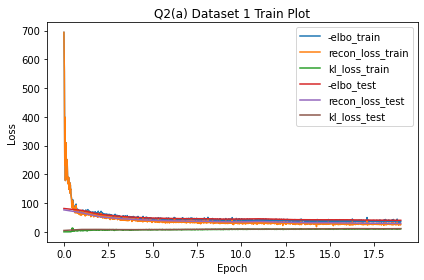

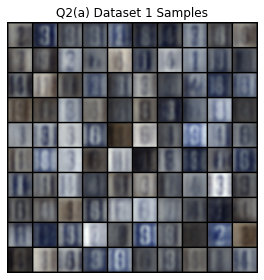

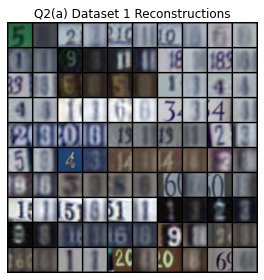

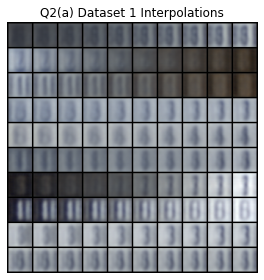

In [38]:
q2_save_results('a', 1, q2_a)

Final -ELBO: 77.0815, Recon Loss: 59.8292, KL Loss: 17.2523


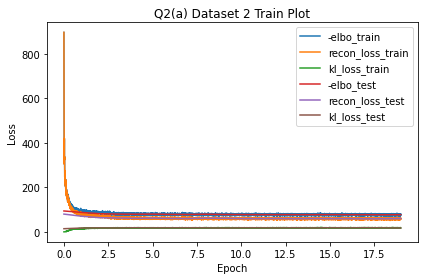

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


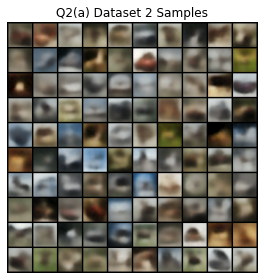

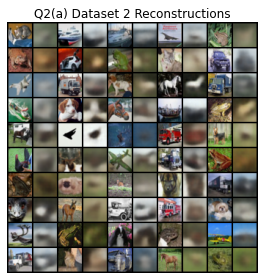

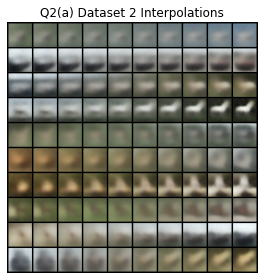

In [32]:
q2_save_results('a', 2, q2_a)

## Part (b) VAE with AF Prior [20pts]
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

**Hint:** Augment your implementation of MADE from previous homeworks and use it for your Autoregressive Prior.

In [12]:
class MaskedLinear(nn.Linear):
  def __init__(self, in_dim, out_dim):
    super().__init__(in_dim, out_dim)
    self.register_buffer('mask', torch.ones(out_dim, in_dim))

  def set_mask(self, mask):
    self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

  def forward(self, input):
    out = F.linear(input, self.mask * self.weight, self.bias)
    return out

class MADE(nn.Module):
  def __init__(self, latent_dim, hidden_size_list):
    super().__init__()
    self.latent_dim = latent_dim
    self.hidden_size_list = hidden_size_list
    model = []
    pre_size = latent_dim
    for l in hidden_size_list + [latent_dim*2]:
      model.append(MaskedLinear(pre_size, l)) 
      model.append(nn.ReLU())
      pre_size = l
    model.pop()
    self.model = nn.Sequential(*model)
    self.m = {} # dictionary for layer numbers for who can come after whom
    self.create_mask()

  def create_mask(self):
    L = len(self.hidden_size_list)
    self.m[-1] = np.arange(self.latent_dim)
    for l in range(L):
      self.m[l] = np.random.randint(self.m[l - 1].min(), self.latent_dim - 1, size=self.hidden_size_list[l]) # 16,512,512 random int from 0 to 15

    masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)] # masks from latent to first hidden, first hidden to second
    masks.append(self.m[L - 1][:, None] < self.m[-1][None, :]) # masks from last hidden to again latent size

    masks[-1] = np.repeat(masks[-1], 2, axis=1) # for every hidden size need two variable for mu and sigma

    layers = [l for l in self.model.modules() if isinstance(l, MaskedLinear)]
    for l, m in zip(layers, masks):
      l.set_mask(m)

  def forward(self, x):
    batch_size = x.shape[0]
    out = x.view(batch_size, self.latent_dim)
    for layer in self.model:
      out = layer(out)
    out = out.view(batch_size, self.latent_dim, 2) # every dim in latent gets one mu and one sigma
    return out

class AFVAE(nn.Module):
  """ YOUR CODE HERE """
  def __init__(self, latent_dim = 16):
    super().__init__()
    self.latent_dim = latent_dim
    self.made = MADE(latent_dim, hidden_size_list=[512, 512])
    self.encoder = ConvEncoder(latent_dim)
    self.decoder = ConvDecoder(latent_dim)

  def train_batch(self,x):
    mu_z, log_std_z = self.encoder(x)
    z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
    x_recon = self.decoder(z)

    #reconstruction loss
    recon_loss = F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1).sum(1).mean()

    out = self.made(z)
    mu, log_std = out.chunk(2, dim=-1)
    log_std = torch.tanh(log_std)
    mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
    eps = z * torch.exp(log_std) + mu

    #kl term KL(q(z|x)||p(z|x)) = KL(encoder||decoder)
    enc_log_prob = -0.5 * np.log(2 * np.pi) - log_std_z - 0.5 * (z - mu_z) ** 2 * torch.exp(-2 * log_std_z)
    prior_log_prob = -0.5 * np.log(2 * np.pi) + log_std - 0.5 * eps ** 2
    kl_loss = (enc_log_prob - prior_log_prob).sum(1).mean()

    loss = recon_loss + kl_loss

    return loss, recon_loss, kl_loss

  def sample(self, n):
    with torch.no_grad():
      z = torch.randn(n, self.latent_dim).cuda()
      for i in range(self.latent_dim):
        mu, log_std = self.made(z)[:, i].chunk(2, dim=-1)
        log_std = torch.tanh(log_std)
        mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
        z[:, i] = (z[:, i] - mu) * torch.exp(-log_std)
      return self.decoder(z).cpu().permute(0, 2, 3, 1).numpy() 

\begin{equation}
  \begin{aligned}
KL(q(z|x)||p(z|x)) &= KL(encoder||decoder)\\
 &= \mathbb{E}_{z} \left(-\frac{1}{2}log\ 2\pi - log\ \sigma_z -\frac{1}{2}\frac{(z-\mu_z)^2}{\sigma_z^2}\right) - \left( -\frac{1}{2}log\ 2\pi + log\ \sigma_{made} - \frac{1}{2}(z\sigma_{made}+\mu_{made})^2\right)
   \end{aligned}
 \end{equation} 





In [20]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = AFVAE(latent_dim = 16).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)

    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    losses, recon_losses, kl_losses, test_losses, test_recon_losses, test_kl_losses = [], [], [], [], [], []

    for epoch in range(20):
      model.train()
      lss, recon_lss, kl_lss = [], [], []
      for x in train_loader:
        x = x.cuda()
        loss, recon_loss, kl_loss = model.train_batch(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lss.append(loss.item())
        recon_lss.append(recon_loss.item())
        kl_lss.append(kl_loss.item())

      losses.extend(lss)
      recon_losses.extend(recon_lss)
      kl_losses.extend(kl_lss)

      test_lss, test_recon_lss, test_kl_lss = eval_loss(model, test_loader)
      test_losses.append(test_lss)
      test_recon_losses.append(test_recon_lss)
      test_kl_losses.append(test_kl_lss)

    train_losses = np.stack((losses, recon_losses, kl_losses), axis=1)
    test_losses = np.stack((test_losses, test_recon_losses, test_kl_losses), axis=1)

    samples = model.sample(100)
    samples = (samples / samples.max())*255

    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z, _ = model.encoder(x)
        x_recon = model.decoder(z)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32)
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy()
    reconstructions = (reconstructions/reconstructions.max()) * 255

    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
    interps = interps.permute(0, 2, 3, 1).cpu().numpy()
    interps = (interps / interps.max()) * 255


    return train_losses, test_losses, samples, reconstructions, interps

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

Final -ELBO: 42.5666, Recon Loss: 32.6681, KL Loss: 9.8985


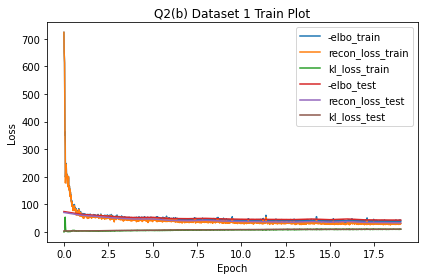

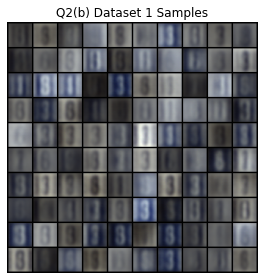

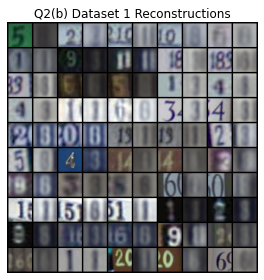

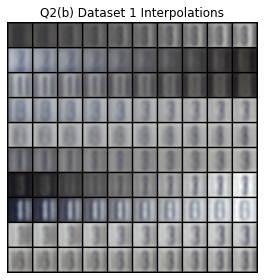

In [21]:
q2_save_results('b', 1, q2_b)

Final -ELBO: 77.6128, Recon Loss: 60.4895, KL Loss: 17.1232


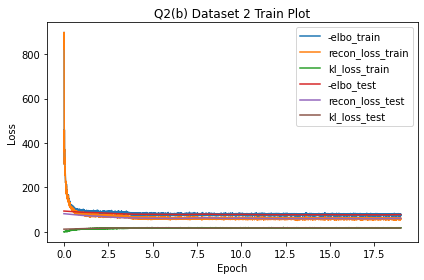

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


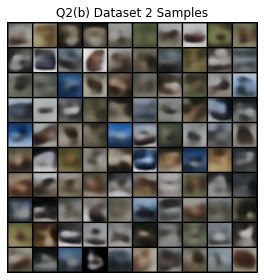

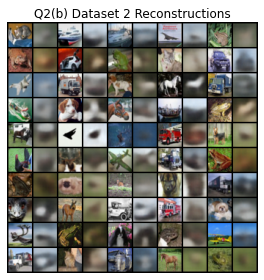

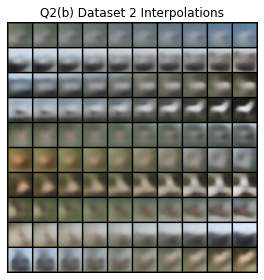

In [22]:
q2_save_results('b', 2, q2_b)

# Question 3: Representation Learning with BiGAN on MNIST [40pt]

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done!


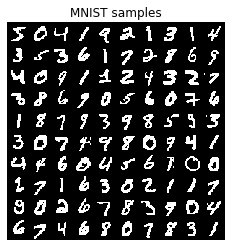

In [ ]:
visualize_q3_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


## Solution
You may want to take a look at the documentation of ```torch.optim.lr_scheduler.LambdaLR ``` for the scheduling of the learning rate (step size). It should linearly decrease to 0 as described above

Pseudocodes for the forward passes of each architecture are given in the following cells. Please check Appendix C.1 of the paper for details.

**Do not forget to report the accuracy of your linear classifiers (one with BiGAN encoder, one with random encoder). You will use these values in your report.**

Training your BiGAN for 100 epochs and training the linear classifiers for 50 epochs each should take no more than an hour in total.

In [5]:
from tqdm.notebook import trange, tqdm
global _use_gpu
global device
global _gpu_id
_gpu_id = 0
_use_gpu = True
device = torch.device("cuda:" + str(0) if _use_gpu else "cpu")

In [6]:
class Generator(nn.Module):
  ###################### PSEUDOCODE ##########################
  # linear(g_input_dim, 1024),
  # relu(),
  # linear(1024, 1024),
  # batchnorm1d(1024, affine=False),
  # relu(),
  # linear(1024, 784),
  # tanh(),
  # reshape(batchsize, 1, 28, 28)
  """ YOUR CODE HERE """
  def __init__(self, g_input_dim, g_output_dim):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(g_input_dim, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1024),
        nn.BatchNorm1d(1024, affine=False),
        nn.ReLU(),
        nn.Linear(1024, g_output_dim),
        nn.Tanh()
        )

  def forward(self, x):
    return self.model(x).reshape(x.shape[0], 1, 28, 28)


In [7]:
class Discriminator(nn.Module):
  ###################### PSEUDOCODE ##########################
  # cat((z, x), dim=1),
  # linear(z_dim + x_dim, 1024),
  # leakyrelu(0.2),
  # linear(1024, 1024),
  # batchnorm1d(1024, affine=False),
  # leakyrelu(0.2),
  # linear(1024, 1),
  # sigmoid()
  """ YOUR CODE HERE """
  def __init__(self, z_dim, x_dim):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(z_dim + x_dim, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 1024),
        nn.BatchNorm1d(1024, affine=False),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 1),
        nn.Sigmoid()
        )

  def forward(self, z, x):
    x = torch.cat((z, x), dim=1)
    return self.model(x)


In [8]:
class Encoder(nn.Module):
  ###################### PSEUDOCODE ##########################
  # view(x.shape[0], -1),
  # linear(input_dim, 1024),
  # leakyrelu(0.2),
  # linear(1024, 1024),
  # batchnorm1d(1024, affine=False),
  # leakyrelu(0.2),
  # linear(1024, output_dim),
  """ YOUR CODE HERE """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(input_dim, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, 1024),
        nn.BatchNorm1d(1024, affine=False),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, output_dim),
        )

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    return self.model(x)

In [12]:
class Solver(object):
  def __init__(self, train_data, test_data, n_epochs=100, batch_size=128, latent_dim=50):
    self.log_interval = 100
    self.batch_size = batch_size
    self.train_loader, self.test_loader = self.create_loaders(train_data, test_data)
    self.n_batches_in_epoch = len(self.train_loader)
    self.n_epochs = n_epochs
    self.curr_itr = 0
    self.latent_dim = latent_dim

  def build(self):
    # BiGAN 
    self.discriminator = Discriminator(self.latent_dim, 784).to(device)
    self.encoder = Encoder(784, self.latent_dim).to(device) 
    self.generator = Generator(self.latent_dim, 784).to(device)  
    self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
    self.g_optimizer = torch.optim.Adam(list(self.encoder.parameters()) + list(self.generator.parameters()), lr=2e-4, betas=(0.5, 0.999), weight_decay=2.5e-5)
    self.g_scheduler = torch.optim.lr_scheduler.LambdaLR(self.g_optimizer,lambda epoch: (self.n_epochs - epoch) / self.n_epochs,last_epoch=-1)
    self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0, 0.9))
    self.d_scheduler = torch.optim.lr_scheduler.LambdaLR(self.d_optimizer,lambda epoch: (self.n_epochs - epoch) / self.n_epochs,last_epoch=-1)
        
    # linear classifier 
    self.linear = nn.Linear(self.latent_dim, 10).to(device)
    self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)

  def reset_linear(self):
    self.linear = nn.Linear(self.latent_dim, 10).to(device)
    self.linear_optimizer = torch.optim.Adam(self.linear.parameters(), lr=1e-3)

  def create_loaders(self, train_data, test_data):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

    return train_loader, test_loader

  def get_discriminator_loss(self, x):
    z_fake = torch.normal(torch.zeros(x.shape[0], self.latent_dim), torch.ones(x.shape[0], self.latent_dim)).to(device)
    z_real = self.encoder(x).reshape(x.shape[0], self.latent_dim)
    x_fake = self.generator(z_fake).reshape(x.shape[0], -1)
    x_real = x.view(x.shape[0], -1)

    d_loss = - 0.5 * (self.discriminator(z_real, x_real)).log().mean() - 0.5 * (1 - self.discriminator(z_fake, x_fake)).log().mean()
    return d_loss


  def train_bigan(self):
    train_losses = []
    val_losses = []
    for epoch_i in tqdm(trange(self.n_epochs), desc='Epoch'):
      epoch_i += 1

      self.discriminator.train()
      self.generator.train()
      self.encoder.train()
      self.batch_loss_history = []

      for batch_i, (x, y) in enumerate(tqdm(self.train_loader, desc='Batch', leave=False)):
        batch_i += 1
        self.curr_itr += 1
        x = x.to(device).float()

        # do a minibatch update
        self.d_optimizer.zero_grad()
        d_loss = self.get_discriminator_loss(x)
        d_loss.backward()
        self.d_optimizer.step()

        # generator and encoder update
        self.g_optimizer.zero_grad()
        g_loss = -self.get_discriminator_loss(x)
        g_loss.backward()
        self.g_optimizer.step()

        self.batch_loss_history.append(d_loss.item())

      # step the learning rate
      self.g_scheduler.step()
      self.d_scheduler.step()
      epoch_loss = np.mean(self.batch_loss_history)
      train_losses.append(epoch_loss)

    train_losses = np.array(train_losses)

    return train_losses

  def train_linear_classifier(self):
    train_losses = []
    val_accs = []       
    for epoch_i in tqdm(trange(self.n_epochs // 2), desc='Epoch'):
      epoch_i += 1

      self.encoder.eval()
      self.linear.train()
      self.batch_loss_history = []

      for batch_i, (x, y) in enumerate(tqdm(self.train_loader, desc='Batch', leave=False)):
        batch_i += 1
        self.curr_itr += 1
        x = x.to(device).float() # * 2 - 1
        y = y.to(device)

        # calculate loss, take gradient step
        self.linear_optimizer.zero_grad()
        z = self.encoder(x).detach()
        pred = self.linear(z)
        linear_loss = F.cross_entropy(pred, y)
        linear_loss.backward()
        self.linear_optimizer.step()

        self.batch_loss_history.append(linear_loss.item())

      val_acc = self.val_acc()
      val_accs.append(val_acc)
      epoch_loss = np.mean(self.batch_loss_history)
      train_losses.append(epoch_loss)

    train_losses = np.array(train_losses)
    val_accs = np.array(val_accs)

    return train_losses, val_accs

  def sample(self, n):
    self.generator.eval()
    with torch.no_grad():
      z = (torch.rand(n, self.latent_dim).to(device) - 0.5) * 2
      samples = self.generator(z).reshape(-1, 1, 28, 28)
    return samples.to('cpu').detach().numpy()
    
  def get_reconstructions(self, x):
    self.generator.eval()
    self.encoder.eval()
    with torch.no_grad():
      z = self.encoder(x)
      recons = self.generator(z).reshape(-1, 1, 28, 28)
    return recons.to('cpu').detach().numpy()

  def val_acc(self):
    self.encoder.eval()
    self.linear.eval()

    val_acc_total = 0
    val_items = 0
    with torch.no_grad():
      for (inputs, labels) in self.test_loader:
        inputs = inputs.to(device).float()
        z = self.encoder(inputs)
        labels = labels.to(device)
        logits = self.linear(z)
        predictions = torch.argmax(logits, dim=1)
        num_correct = torch.sum(predictions == labels).float()
        val_acc_total += num_correct
        val_items += inputs.shape[0]

    return (val_acc_total / val_items).to('cpu').detach().numpy()

**BIGAN:**
* discriminator loss (z:latent space (dim=50), x:data space (28x28 picture))
$$z_{fake} \sim \mathcal{N}(0,1)$$
$$z_{real} = MLP_{encoder}(x)$$
$$x_{fake} = MLP_{generator}(z_{fake})$$
$$loss = - \frac{1}{2}\mathbb{E}_x\left[log\ MLP_{discriminator}(concat(z_{real},x))-\frac{1}{2}(1-MLP_{discriminator}(concat(z_{fake},x_{fake})))\right]$$

* generator loss = - discriminator loss
<br>

**LINEAR CLASSIFIER (work with BIGAN trained encoder and random encoder):**
 $$z = MLP_{encoder}(x)$$
 $$pred = MLP_{classifier}(z)$$
 $$loss = CrossEntropy(pred,realClass)$$

In [10]:
def q3(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    """ YOUR CODE HERE """
    solver = Solver(train_data, test_data, n_epochs=100)
    solver.build()

    # get random encoder accuracy
    print("Training linear classifier on random encoder")
    train_losses, val_accs = solver.train_linear_classifier()

    # train bigan
    print("Training BiGAN")
    bigan_losses = solver.train_bigan()
    samples = solver.sample(100).transpose(0, 2, 3, 1) * 0.5 + 0.5
    train_images = train_data.data[:20].reshape(20, 1, 28, 28) / 255.0
    train_img_tensor = torch.FloatTensor(train_images).to(device) * 2 - 1
    recons = solver.get_reconstructions(train_img_tensor) * 0.5 + 0.5

    # see benefit of unsupervised learning
    solver.reset_linear()
    print("Training linear classifier on BiGAN encoder")
    bigan_train_losses, bigan_val_accs = solver.train_linear_classifier()

    print(f"Final BiGAN test linear accuracy: {bigan_val_accs[-1]}")
    print(f"Final random encoder test linear accuracy: {val_accs[-1]}")

    return bigan_losses, samples, np.concatenate([train_images, recons], axis=0).transpose(0, 2, 3, 1), bigan_train_losses, train_losses


## Results

Training linear classifier on random encoder




Training BiGAN




Training linear classifier on BiGAN encoder




Final BiGAN test linear accuracy: 0.8648999929428101
Final random encoder test linear accuracy: 0.7906000018119812


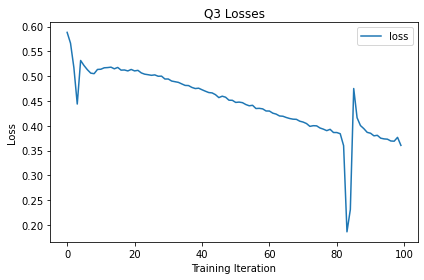

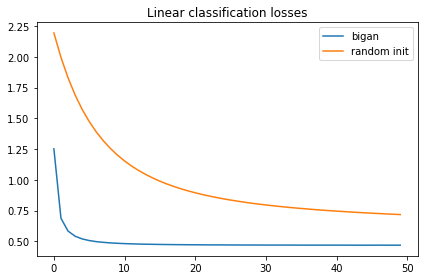

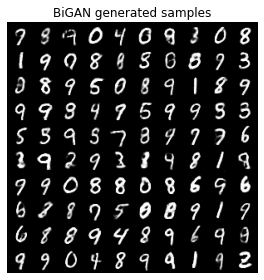

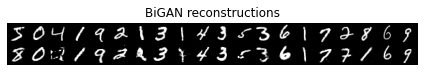

BiGAN final linear classification loss: 0.4690117031526464
Random encoder linear classification loss: 0.7179417563145603


In [13]:
q3_save_results(q3)

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

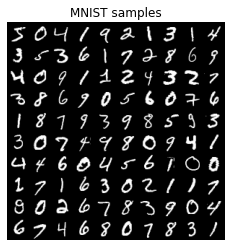

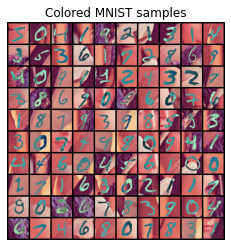

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

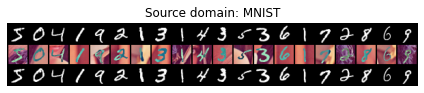

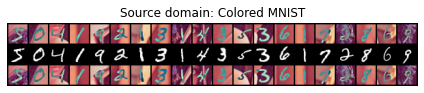

In [ ]:
q4_save_results(q4)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)

*This assignment is adapted from UC Berkeley [CS294-158-SP20](https://sites.google.com/view/berkeley-cs294-158-sp20/home)*